In [1]:
# import sys
# sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet')

from mpc.cem_mpc_teb import MPC
from mpc.systems.acrobot_vec_tv import Acrobot

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import pickle
 
def load_data(model, env, traj_id):
    filepath = lambda var: "/media/arclabdl1/HD1/Linjun/data/kinodynamic/{model}/{env}/{var}_{id}.pkl".format(model=model,env=env, var=var, id=traj_id)      
    load_pkl = lambda var: pickle.load(open(filepath(var), "rb"))
    keys = ["control", "path", "start_goal", "time", 'cost']
    return dict(zip(keys, [load_pkl(key) for key in keys]))
def get_obs(model, filetype):
    def filepath (model, env_id, filetype):
            return "/media/arclabdl1/HD1/Linjun/data/kinodynamic/{model}/{filetype}_{env_id}.pkl".format(model=model, env_id=env_id, filetype=filetype)
    def loader(model, env_id, filetype): 
        return pickle.load(open(filepath(model, env_id, filetype), "rb"))
    #obs_list = [loader(model, env_id, "obs") for env_id in range(10)]
    obs_list = np.array([loader(model, env_id, "obs").reshape(-1, 2) for env_id in range(10)])
    return obs_list

def interpolate_path(start, control, time):
    x = np.expand_dims(start.copy(), axis=0).copy()
    gt_path = []
    for _ in range((time/params['dt']).astype(int)):
        x = model.propagate(x.copy(),
                np.expand_dims(control, axis=0),
                np.ones(1),
                params['dt']).copy()
        gt_path.append(x[0])
    return gt_path, x[0]

env_id = 1
path_id = 233

obs_list = get_obs('acrobot_obs', 0)[env_id]
data = load_data('acrobot_obs', env_id, path_id)
ref_path = data['path']

n_t = 10
state_dim = 4
control_dim = 1
weights = np.ones(state_dim)*1
weights[2:] = 0.25
n_sample = 1024
n_elite = 32
t = 1e-1
dt = 2e-2

mu_t, sigma_t = 5e-2, 2e-1
t_min, t_max = 0, 2e-1

mu_u = np.zeros((n_t*control_dim))
sigma_u_diag = np.ones(n_t*control_dim)
sigma_u_diag[:] = 4
sigma_u = np.diag(sigma_u_diag)
params = {
    'n_sample': n_sample,
    'n_elite': n_elite,
    'n_t': n_t,
    'weights': weights,
    'mu_u': mu_u,
    'sigma_u': sigma_u,
    't': t,
    'dt': dt,
    
    'mu_t': np.ones(n_t) * mu_t,
    'sigma_t': np.identity(n_t)*sigma_t,
    't_min': t_min,
    't_max': t_max,
    
    'state_dim': state_dim,
    'control_dim': control_dim,
    'converge_radius': 1e-1,
    'drop_radius':5e-1,
    'goal_radius':2,
    'max_it': 10,
    'rolling_count': n_t,
    'bk_it': 2,
    'final_goal': np.array([np.inf, np.inf, np.inf, np.inf]), #ref_path[-1],
    'mpc_mode': 'solve',
#     'mpc_mode': 'rolling',

    
}
model = Acrobot()
mpc = MPC(params, model, verbose=True)




In [2]:
i = 5
print(data['cost'][i], data['control'][i])
# start = ref_path[i]
# goal = ref_path[i+1]
# best_x, min_loss, path, collision = mpc.solve(start, goal)
# for n in np.array(path):
#     print(model.get_loss(np.expand_dims(n, axis=0), goal, weights))

start = ref_path[i]
goal = ref_path[i+1]
best_x, min_loss, path, collision, cost, actions = mpc.solve(start.copy(), goal)
print(cost, cost.sum())

0.22 [-1.87637043]
0.22407675587276904 inf
converged at  1
loss: [0.02407676]
[0.  0.2] 0.2


/media/arclabdl1/HD1/Linjun/mpc-mpnet/mpc/systems/acrobot_vec_tv.py:141: RuntimeWarning: invalid value encountered in cos
  x2 = np.cos(goal[0] - np.pi / 2)+np.cos(goal[0] + goal[1] - np.pi / 2)
/media/arclabdl1/HD1/Linjun/mpc-mpnet/mpc/systems/acrobot_vec_tv.py:142: RuntimeWarning: invalid value encountered in sin
  y2 = np.sin(goal[0] - np.pi / 2)+np.sin(goal[0] + goal[1] - np.pi / 2)


In [3]:
path_interp = []
x = start.copy()
for i_t in range(len(actions)):
    path_interp_i, x = interpolate_path(x.copy(), actions[i_t], cost[i_t])
    path_interp += path_interp_i
    
gt_path, gt_x= interpolate_path(start.copy(), data['control'][i], data['cost'][i])


<IPython.core.display.Javascript object>


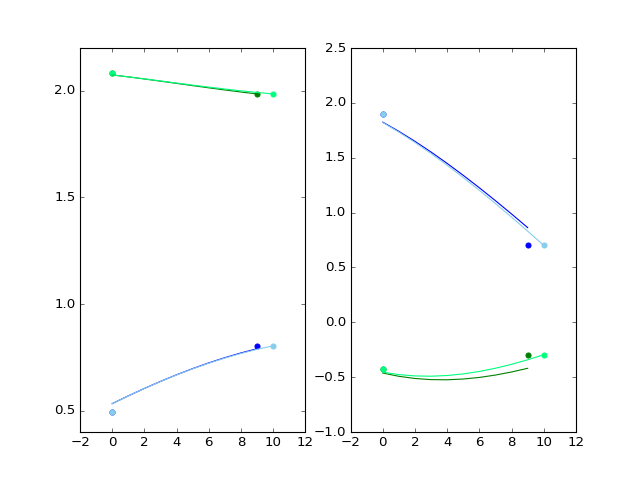

In [4]:
%matplotlib notebook
plt.subplot(1,2,1)
plt.scatter(0, ref_path[i,0], color='blue')
plt.scatter(0, ref_path[i,1], color='green')
plt.scatter(len(path_interp)-1, ref_path[i+1,0], color='blue')
plt.scatter(len(path_interp)-1, ref_path[i+1,1], color='green')
plt.scatter(0, ref_path[i,0], color='skyblue')
plt.scatter(0, ref_path[i,1], color='springgreen')
plt.scatter(len(gt_path)-1, ref_path[i+1,0], color='skyblue')
plt.scatter(len(gt_path)-1, ref_path[i+1,1], color='springgreen')


plt.plot(np.arange(len(path_interp)), np.array(path_interp)[:,0], color='blue')
plt.plot(np.arange(len(path_interp)), np.array(path_interp)[:,1], color='green')

# path angle
plt.plot(np.arange(len(gt_path)), np.array(gt_path)[:,0], color='skyblue')
plt.plot(np.arange(len(gt_path)), np.array(gt_path)[:,1], color='springgreen')

plt.subplot(1,2,2)
plt.scatter(0, ref_path[i,2], color='blue')
plt.scatter(0, ref_path[i,3], color='green')
plt.scatter(len(path_interp)-1, ref_path[i+1, 2], color='blue')
plt.scatter(len(path_interp)-1, ref_path[i+1, 3], color='green')
plt.plot(np.arange(len(path_interp)), np.array(path_interp)[:,2])
plt.plot(np.arange(len(path_interp)), np.array(path_interp)[:,3])

plt.scatter(0, ref_path[i,2], color='skyblue')
plt.scatter(0, ref_path[i,3], color='springgreen')
plt.scatter(len(gt_path)-1, ref_path[i+1, 2], color='skyblue')
plt.scatter(len(gt_path)-1, ref_path[i+1, 3], color='springgreen')
# path vel
plt.plot(np.arange(len(gt_path)), np.array(gt_path)[:,2], color='skyblue')
plt.plot(np.arange(len(gt_path)), np.array(gt_path)[:,3], color='springgreen')



In [43]:
# %%time
mpnet_path = np.load('mpnet/mpnet_path.npy')
node = 15

start = mpnet_path[node].copy()
goal = mpnet_path[node+1].copy()

x = start.copy()
costs = []
full_path = []
path_interp = [start]

print("node number {}".format(node))
x, min_loss, path, collision, cost, actions = mpc.solve(x.copy(), goal.copy(), obs_list=obs_list)
print(cost,sum(cost))
costs.append(sum(cost))

x = start.copy()
for i_t in range(len(actions)):
    path_interp_i, x = interpolate_path(x.copy(), actions[i_t], cost[i_t])
    path_interp += path_interp_i
# print(path_interp)

node number 15
0.44801107197999956 inf
converged at  4
loss: [0.04801107]
[0.  0.  0.2 0.  0.2] 0.4


/media/arclabdl1/HD1/Linjun/mpc-mpnet/mpc/systems/acrobot_vec_tv.py:141: RuntimeWarning: invalid value encountered in cos
  x2 = np.cos(goal[0] - np.pi / 2)+np.cos(goal[0] + goal[1] - np.pi / 2)
/media/arclabdl1/HD1/Linjun/mpc-mpnet/mpc/systems/acrobot_vec_tv.py:142: RuntimeWarning: invalid value encountered in sin
  y2 = np.sin(goal[0] - np.pi / 2)+np.sin(goal[0] + goal[1] - np.pi / 2)


In [44]:
# x, min_loss, path, collision, cost, actions = mpc.solve(x.copy(), mpnet_path[-1], obs_list=obs_list)
print(model.get_distance(goal=mpnet_path[-1], state=np.expand_dims(x,axis=0), weight=[]))

[1.2110066]


<IPython.core.display.Javascript object>


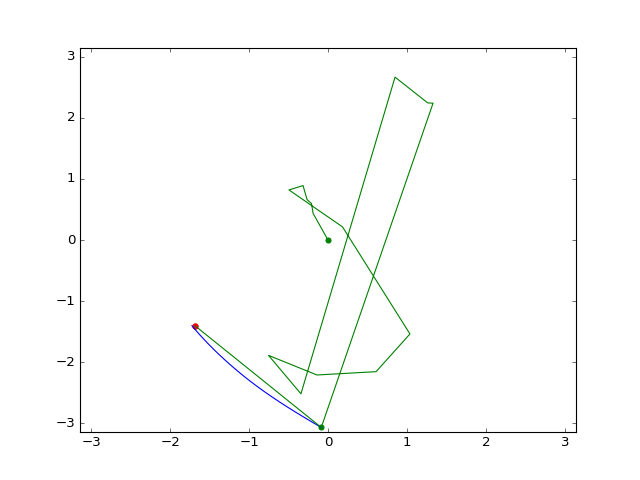

(-3.141592653589793, 3.141592653589793)

In [45]:
%matplotlib notebook
path = np.array(path_interp)

plt.plot(path[:,0], path[:,1], color='blue')
plt.plot(mpnet_path[:,0], mpnet_path[:,1], color='green')

plt.scatter(start[0], start[1], color='green')
plt.scatter(goal[0], goal[1], color='red')

plt.scatter(mpnet_path[0,0], mpnet_path[0,1], color='green')
plt.scatter(mpnet_path[-1,0], mpnet_path[-1,1], color='red')

plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)




In [39]:
path

array([], dtype=float64)

In [21]:
costs = np.array(costs)
costs.sum()

0.47099141998737415

In [22]:
costs

array([0.47099142])

<IPython.core.display.Javascript object>


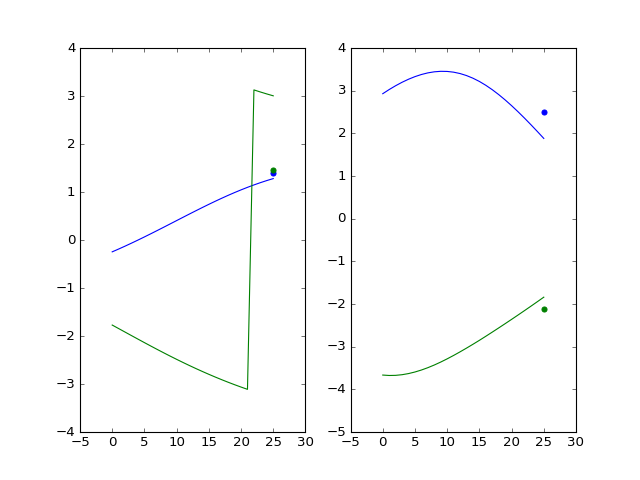

In [115]:
%matplotlib notebook
# path = [list(mpnet_path[node])] + path
# path = np.array(path)
# print(mpnet_path[node], mpnet_path[node+1])

plt.subplot(1,2,1)
plt.plot(np.arange(len(path)), np.array(path)[:, 0])
plt.plot(np.arange(len(path)), np.array(path)[:,1])
plt.scatter(len(path)-1, mpnet_path[node+1,0], color='blue')
plt.scatter(len(path)-1, mpnet_path[node+1,1], color='green')

plt.subplot(1,2,2)
plt.plot(np.arange(len(path)), np.array(path)[:,2])
plt.plot(np.arange(len(path)), np.array(path)[:,3])
plt.scatter(len(path)-1, mpnet_path[node+1, 2], color='blue')
plt.scatter(len(path)-1, mpnet_path[node+1, 3], color='green')


In [43]:
x,mpnet_path[-1]
print(model.get_loss(np.expand_dims(x, axis=0), mpnet_path[-1], weights))
print(model.get_distance(np.expand_dims(x, axis=0), mpnet_path[-1], weights))

[1.0888867]
[30.101892]
